# MSCA 31013 BIG DATA PLATFORMS FINAL PROJECT
### GARIMA SOHI

## MODULE - 3 (MOST PROLIFIC USERS ANALYSIS)

#### 3.1 Importing required packages and libraries for setting up the environment

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
from google.cloud import storage

In [3]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

#### 3.2 Reading the file

In [4]:
tweets = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/gsohi/bdp_final_project_eda')

In [5]:
tweets.count()

8350980

In [6]:
tweets.columns

['user_id',
 'user_name',
 'user_description',
 'user_location',
 'statuses_count',
 'user_verified_status',
 'retweet_user_id',
 'retweet_user_name',
 'retweet_user_description',
 'user_followers_count',
 'place_country',
 'tweet_created_at',
 'is_retweeted',
 'text']

In [7]:
tweets.limit(5).toPandas()

,user_id,user_name,user_description,user_location,statuses_count,user_verified_status,retweet_user_id,retweet_user_name,retweet_user_description,user_followers_count,place_country,tweet_created_at,is_retweeted,text
0,1273842231082803201,달콤,None,None,7660,False,1290203557065416707,Billlie Information 🐈‍⬛,Information for Billlie Member #MoonSua #Suhyeon #Haram #Tsuki #Sheon #Siyoon #Haruna 💜🌝🌸🎀🐰🐱🐣🐢💙,76,None,Sun Sep 25 07:54:06 +0000 2022,RT,Billlie's Schedule‼️\n9/25\n▶️Inkigayo at 3.50PM\n▶️ Fansign Ktown4u Offline at 7PM &amp; Online at 9.30PM\n\n9/27\n▶️ After School Club at 1PM\n▶️ Second World EP5 at 8.50PM 🌝\n\n9/28\n▶️ 2022 Festival Jungbu University at 8.30PM\n\n#빌리 #Billlie
1,1435048419085664265,.,None,None,637,False,1559527150197555200,NewJeans Loops 👖,for #뉴진스 #NewJeans,17,None,Sun Sep 25 07:54:12 +0000 2022,RT,220924 Yonsei University \nHype Boy \n\n#뉴진스 #NewJeans https://t.co/UrZ2I6cAN6
2,1858565390,Jenny Ardley,Love my job (s). Personal account. For Community related posts see @LboroCommunity,Loughborough,9748,False,2641472512,Claire gallerystrong 💥,#Leader aspiring to diversify #nuclear #WINCumbria #NPWAwards #Trustee Royal Society Chemistry #Chemist #Engineer #WeAreNPW #visiblewomen my views only,979,None,Sun Sep 25 07:54:13 +0000 2022,RT,Well look what i found at a university open day. A #WomenInSTEM group for Loughborough Uni. 💕the networks forming to help more gender balance in STEM @lborouniversity @LboroWIS @thewisecampaign @WES1919 https://t.co/HSjurHT99K
3,1257835150253023233,내 조그만 우주💫,*a fanacc* our little wonshim universe 💫 🚫BLOCK ME🚫 if u dont like the content 😌 #DO (D.O.) #Kyungsoo #DohKyungSoo #NamJihyun,None,54690,False,1436345937400586284,sam 🧃🧸,내가 제일 좋아하는 사람,1713,None,Sun Sep 25 07:54:28 +0000 2022,RT,"220924 | Kyungsoo's sign at a high school dated September 19 😭😭\n\nStudents are preparing for the CSAT and Kyungsoo left a message for third, fourth, fifth &amp; sixth graders:\n\n""Hope you succeed on the CSAT\nDoh Kyungsoo""\n\n#DOHKYUNGSOO #엑소디오 #디오 #DO(D.O.) #도경수 https://t.co/5kU3B88lza"
4,1350425599207211009,Muhammad Irfan Zafar,From The Darkest Day and The Hardest Rain The Brightest Flowers Grow✨✨,None,174,False,1193584683692576768,Mahar Zeeshan,EnToMoLogiSt🐞\n#Mphill_Scholar_at_SHZU_China\n#Leo💪\n#NaTuRe_LoVer💓💚,27,None,Sun Sep 25 07:54:32 +0000 2022,RT,"@MIrfanZafar8 @JiRongMFA Dear Mam\nI appreciate your efforts for int. Students. When all students from other Provinces are going back to their universities, Students of #Xinjiang are still being ignored even the Covid is over. Why? Plz take an Action on this Nd issue us NOCs.\n#takeUsBackToChina"


In [6]:
tweets = tweets.withColumn('NEWS_ORGANIZATIONS', F.when( F.col('user_description').contains('news') | \
                                              F.col('user_description').contains('wire service') | \
                                              F.col('user_description').contains('press agency') | \
                                              F.col('user_description').contains('press association') | \
                                              F.col('user_description').contains('the press') | \
                                              F.col('user_description').contains('publication') | \
                                              F.col('user_description').contains('publications'),"true")).\
withColumn('NON_PROFIT_ORGANIZATIONS', F.when( F.col('user_description').contains('nonprofit') \
                                               | F.col('user_description').contains('non-profit') \
                                               | F.col('user_description').contains('charitable') \
                                               | F.col('user_description').contains('public service') \
                                               | F.col('user_description').contains('voluntary') \
                                               | F.col('user_description').contains('cause') \
                                               | F.col('user_description').contains('public fund') \
                                               | F.col('user_description').contains('movement') \
                                               | F.col('user_description').contains('beneficiary') \
                                               | F.col('user_description').contains('philanthropic'),"true")). \
withColumn('ACADEMIC_INSTITUTIONS',
    F.when(F.col('user_name').contains('university') \
           | F.col('user_name').contains('school') \
           | F.col('user_description').contains('university') \
           | F.col('user_description').contains('school') \
           | F.col('user_description').contains('uni') \
           | F.col('user_description').contains('college') \
           | F.col('user_description').contains('research'),"true")).\
withColumn('GOVERNMENT_INSTITUTIONS',
    F.when(F.col('user_name').contains('gov') \
           | F.col('user_name').contains('govt') \
           | F.col('user_name').contains('govt.') \
           | F.col('user_name').contains('government') \
           | F.col('user_name').contains('public') \
           | F.col('user_description').contains('gov') \
           | F.col('user_description').contains('government') \
           | F.col('user_description').contains('public') \
           | F.col('user_description').contains('judiciary') \
           | F.col('user_description').contains('tutoring') \
           | F.col('user_description').contains('legislative') \
           | F.col('user_description').contains('authoritarian state') \
           | F.col('user_description').contains('civil service') \
           | F.col('user_description').contains('administrative') \
           | F.col('user_description').contains('supervisory') \
           | F.col('user_description').contains('bureaucratic'),"true")).\
withColumn('SOCIAL_MEDIA_INFLUENCERS',
    F.when( F.col('user_description').contains('influencer') \
           | F.col('user_description').contains('social media') \
           | F.col('user_description').contains('inspires') \
           | F.col('user_description').contains('motivates') \
           | F.col('user_description').contains('influences') \
           | F.col('user_description').contains('trendsetters') \
           | F.col('user_description').contains('trend') ,"true")).\
withColumn('OTHERS',
    F.when( F.col('user_description').contains('business') \
           | F.col('user_description').contains('group') \
           | F.col('user_description').contains('job portal') \
           | F.col('user_description').contains('finance') \
           | F.col('user_description').contains('banking') \
           | F.col('user_description').contains('tutoring') \
           | F.col('user_description').contains('financial') \
           | F.col('user_description').contains('social media') \
           | F.col('user_description').contains('influencer') \
           | F.col('user_description').contains('show') ,"true"))

In [7]:
tweets.columns

['user_id',
 'user_name',
 'user_description',
 'user_location',
 'statuses_count',
 'user_verified_status',
 'retweet_user_id',
 'retweet_user_name',
 'retweet_user_description',
 'user_followers_count',
 'place_country',
 'tweet_created_at',
 'is_retweeted',
 'text',
 'NEWS_ORGANIZATIONS',
 'NON_PROFIT_ORGANIZATIONS',
 'ACADEMIC_INSTITUTIONS',
 'GOVERNMENT_INSTITUTIONS',
 'SOCIAL_MEDIA_INFLUENCERS',
 'OTHERS']

#### 3.3 Identifying top twitterers by total tweets (both original tweets and retweets)

In [9]:
tweets_v = tweets.filter(tweets.user_verified_status == 'True')

In [132]:
total_tweets_news = tweets_v.filter(tweets_v.NEWS_ORGANIZATIONS == 'true')
total_tweets_news = total_tweets_news.groupby('user_id','NEWS_ORGANIZATIONS').agg(max('statuses_count')).orderBy('max(statuses_count)',ascending=False).na.drop()
total_tweets_news = total_tweets_news.toPandas().set_index('NEWS_ORGANIZATIONS')
total_tweets_news = total_tweets_news.rename(columns = {'max(statuses_count)':'total_tweets'})
total_tweets_news

,user_id,total_tweets
NEWS_ORGANIZATIONS,,
true,322010071,1225988
true,36327407,1150717
true,18129942,1096234
true,19897138,1089216
true,1917731,1064390
...,...,...
true,535915970,105
true,1420714823281565699,85
true,1270131565998166017,55


In [133]:
total_tweets_np = tweets_v.filter(tweets_v.NON_PROFIT_ORGANIZATIONS == 'true')
total_tweets_np = total_tweets_np.groupby('user_id','NON_PROFIT_ORGANIZATIONS').agg(max('statuses_count')).orderBy('max(statuses_count)',ascending=False).na.drop()
total_tweets_np = total_tweets_np.toPandas().set_index('NON_PROFIT_ORGANIZATIONS')
total_tweets_np = total_tweets_np.rename(columns = {'max(statuses_count)':'total_tweets'})
total_tweets_np

,user_id,total_tweets
NON_PROFIT_ORGANIZATIONS,,
true,4170491,335357
true,32608975,237072
true,36589823,220996
true,47418503,212055
true,2174828818,210377
...,...,...
true,1246008111678271488,196
true,1496883253231468550,154
true,19784391,78


In [134]:
total_tweets_acad = tweets_v.filter(tweets_v.ACADEMIC_INSTITUTIONS == 'true')
total_tweets_acad = total_tweets_acad.groupby('user_id','ACADEMIC_INSTITUTIONS').agg(max('statuses_count')).orderBy('max(statuses_count)',ascending=False).na.drop()
total_tweets_acad = total_tweets_acad.toPandas().set_index('ACADEMIC_INSTITUTIONS')
total_tweets_acad = total_tweets_acad.rename(columns = {'max(statuses_count)':'total_tweets'})
total_tweets_acad

,user_id,total_tweets
ACADEMIC_INSTITUTIONS,,
true,16676396,1144944
true,2868388510,1097228
true,378809160,1006753
true,330826792,946119
true,117685967,869965
...,...,...
true,1308101216937766912,64
true,1490762670642978819,52
true,388729847,51


In [135]:
total_tweets_gov = tweets_v.filter(tweets_v.GOVERNMENT_INSTITUTIONS == 'true')
total_tweets_gov = total_tweets_gov.groupby('user_id','GOVERNMENT_INSTITUTIONS').agg(max('statuses_count')).orderBy('max(statuses_count)',ascending=False).na.drop()
total_tweets_gov = total_tweets_gov.toPandas().set_index('GOVERNMENT_INSTITUTIONS')
total_tweets_gov = total_tweets_gov.rename(columns = {'max(statuses_count)':'total_tweets'})
total_tweets_gov

,user_id,total_tweets
GOVERNMENT_INSTITUTIONS,,
true,171574926,815449
true,811972460560019456,530504
true,19584103,395247
true,71082732,359630
true,180748385,339281
...,...,...
true,1504659674846707715,52
true,1543051562712530944,50
true,1519884473692680192,43


In [136]:
total_tweets_soc = tweets_v.filter(tweets_v.SOCIAL_MEDIA_INFLUENCERS == 'true')
total_tweets_soc = total_tweets_soc.groupby('user_id','SOCIAL_MEDIA_INFLUENCERS').agg(max('statuses_count')).orderBy('max(statuses_count)',ascending=False).na.drop()
total_tweets_soc = total_tweets_soc.toPandas().set_index('SOCIAL_MEDIA_INFLUENCERS')
total_tweets_soc = total_tweets_soc.rename(columns = {'max(statuses_count)':'total_tweets'})
total_tweets_soc

,user_id,total_tweets
SOCIAL_MEDIA_INFLUENCERS,,
true,330826792,886870
true,17710740,691929
true,44374617,423675
true,445068987,362930
true,1106310289711120384,324584
...,...,...
true,278586112,901
true,1113199492222849030,667
true,951353274950701056,635


In [137]:
total_tweets_others = tweets_v.filter(tweets_v.OTHERS == 'true')
total_tweets_others = total_tweets_others.groupby('user_id','OTHERS').agg(max('statuses_count')).orderBy('max(statuses_count)',ascending=False).na.drop()
total_tweets_others = total_tweets_others.toPandas().set_index('OTHERS')
total_tweets_others = total_tweets_others.rename(columns = {'max(statuses_count)':'total_tweets'})
total_tweets_others

,user_id,total_tweets
OTHERS,,
true,322010071,1225988
true,1652541,918120
true,560711367,845568
true,34713362,821772
true,39975533,707898
...,...,...
true,306116656,97
true,1509893030781853699,97
true,1500605525683232770,87


In [138]:
ttl_tweets_news = total_tweets_news['total_tweets'].sum()
ttl_tweets_np = total_tweets_np['total_tweets'].sum()
ttl_tweets_acad = total_tweets_acad['total_tweets'].sum()
ttl_tweets_gov = total_tweets_gov['total_tweets'].sum()
ttl_tweets_soc = total_tweets_soc['total_tweets'].sum()
ttl_tweets_others = total_tweets_others['total_tweets'].sum()

print('Total tweets by news organizations: ', (ttl_tweets_news.astype(float)/1000000).astype(str) + 'MM')
print('Total tweets by non-profit organizations: ', (ttl_tweets_np.astype(float)/1000000).astype(str) + 'MM')
print('Total tweets by academic institutions: ', (ttl_tweets_acad.astype(float)/1000000).astype(str) + 'MM')
print('Total tweets by govt institutions: ', (ttl_tweets_gov.astype(float)/1000000).astype(str) + 'MM')
print('Total tweets by social media influencers: ', (ttl_tweets_soc.astype(float)/1000000).astype(str) + 'MM')
print('Total tweets by others: ', (ttl_tweets_others.astype(float)/1000000).astype(str) + 'MM')

Total tweets by news organizations:  287.605321MM
Total tweets by non-profit organizations:  12.481969MM
Total tweets by academic institutions:  114.076251MM
Total tweets by govt institutions:  43.987955MM
Total tweets by social media influencers:  14.30525MM
Total tweets by others:  65.586208MM


In [139]:
total_tweets_y = [ttl_tweets_news.astype(float)/1000000,\
                  ttl_tweets_np.astype(float)/1000000,\
                  ttl_tweets_acad.astype(float)/1000000,\
                  ttl_tweets_gov.astype(float)/1000000,\
                  ttl_tweets_soc.astype(float)/1000000,\
                  ttl_tweets_others.astype(float)/1000000]
total_tweets_x = ['NEWS_ORGS', 'NON-PROFIT ORGS', 'ACADEMIC INSTITUTIONS', 'GOVT INSTITUTIONS', 'SOCIAL MEDIA INFLUENCERS', 'OTHERS']

In [140]:
df_total_tweets = pd.DataFrame(total_tweets_x,total_tweets_y)

#### 3.4 Identifying top twitterers by original tweets

Filtering rows where tweets are not retweeted.

In [141]:
#Part-1 Overall Users
tweets_original = tweets.filter(tweets.is_retweeted != 'RT')

Grouping rows by user_name and aggregating rows by counting the total tweets by the user.

In [142]:
org = tweets_original.groupby('user_name','user_description').agg(count(('text'))).orderBy('count(text)',ascending=False)
org = org.toPandas()
org = org.rename(columns = {'count(text)':'total_original_tweets'})
org.head(10)

22/12/08 00:37:11 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 44 for reason Container marked as failed: container_1670452426200_0002_01_000049 on host: hub-msca-bdp-dphub-students-backup-gsohi-sw-9b4p.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.


,user_name,user_description,total_original_tweets
0,NJSchoolJobs.com,The leading advertiser of education jobs for New Jersey's Schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,7846
1,Dennis Stemmle,"Founder - College Success Academy, #1 Best-Selling Author, Entrepreneur, Speaker, Lecturer at The Wall College of Business - Coastal Carolina University",6773
2,edibeeee,.,4788
3,Personal Growth,Follow for exclusive #deals and #selfhelp resources. #OnlineDeals for you.,4297
4,UnlockedMaps Toronto,UnlockedMaps Toronto,3914
5,Frontend.LA,Please donate some $DOGE @ D7Sz2quBuzDVQeT34vM1V5EzSrCfNn4eP2,3332
6,Parent Security,#Parents who want to keep their #children #safe #Read #ParentSecurity. #teens #kids #schoolshooting #schoolsafety,3033
7,Ladonna Long,ladonna,2238
8,Wadhama Sporet,maksil,2124
9,On Sports New,On Sports New,2058


In [143]:
org_top10 = org.head(10)

In [13]:
#Part-2 Verified Users
tweets_original_v = tweets_v.filter(tweets_v.is_retweeted != 'RT')

In [145]:
org_v = tweets_original_v.groupby('user_name','user_description').agg(count(('user_id'))).orderBy('count(user_id)',ascending=False)
org_v = org_v.toPandas()
org_v = org_v.rename(columns = {'count(user_id)':'total_original_tweets'})
org_v.head(10)

,user_name,user_description,total_original_tweets
0,ExploreLearning,"We make Gizmos, Reflex, Frax, and Science4Us: innovative, seriously fun math and science online solutions for K-12 classrooms.",485
1,Queensland Ambulance,Official account of the Queensland Ambulance Service. Do not use this account to request emergency assistance. In an emergency call TRIPLE ZERO (000).,443
2,People's Mojahedin Organization of Iran (PMOI/MEK),"Official account of PMOI/MEK, the main Iranian opposition group seeking to establish a free, democratic & non-nuclear Iran at peace with the world.\n@PMOIRAN",400
3,Iran News Update,"Iran News Update (INU) features original news, analysis, and commentary on Iran events.\n#IranProtests\n#IranRevolution\n\n🔴DM is open to echoing protesters' voice",366
4,IANS,India's largest independent News Agency,333
5,Iran News Update,"Iran News Update (INU) features original news, analysis, and commentary on events inside/outside Iran.\n#IranProtests\n#IranToday",331
6,DT Next,"DT Next is the English daily from Daily Thanthi group. With a micro-focus on Chennai & TN, DT Next offers incisive coverage on politics, sports, features & ent.",323
7,Keung Hui,"I'm a K-12 education reporter for @newsobserver. I also tweet about history, baseball & science fiction. Retweets aren’t endorsements -- unless about @Yankees.",312
8,JoyNews,24/7 TV news channel in Ghana since 2010 | Part of the Multimedia Group | Independent. Fearless. Credible.,264
9,TIMES NOW,TIMES NOW is India’s most watched English news channel. Follow for lightning fast #BreakingNews and #Alerts.,257


In [146]:
org_v_top10 = org_v.head(10)

In [29]:
#Part-3 Organization Distributions
org_tweets_news = tweets_original_v.filter(tweets_original_v.NEWS_ORGANIZATIONS == 'true')
org_tweets_news = org_tweets_news.groupby('user_id','NEWS_ORGANIZATIONS').agg(count('text')).orderBy('count(text)',ascending=False).na.drop()
org_tweets_news = org_tweets_news.toPandas().set_index('NEWS_ORGANIZATIONS')
org_tweets_news = org_tweets_news.rename(columns = {'count(text)':'total_original_tweets'})
org_tweets_news

,user_id,total_original_tweets
NEWS_ORGANIZATIONS,,
true,1383920448,717
true,53754251,312
true,610124383,264
true,240649814,257
true,898251204,226
...,...,...
true,997154663106600960,1
true,29331255,1
true,925027774099873793,1


In [30]:
org_tweets_np = tweets_original_v.filter(tweets_original_v.NON_PROFIT_ORGANIZATIONS == 'true')
org_tweets_np = org_tweets_np.groupby('user_id','NON_PROFIT_ORGANIZATIONS').agg(count('text')).orderBy('count(text)',ascending=False).na.drop()
org_tweets_np = org_tweets_np.toPandas().set_index('NON_PROFIT_ORGANIZATIONS')
org_tweets_np = org_tweets_np.rename(columns = {'count(text)':'total_original_tweets'})
org_tweets_np

,user_id,total_original_tweets
NON_PROFIT_ORGANIZATIONS,,
true,26752156,136
true,1273698355,75
true,26299078,56
true,32608975,52
true,1304864108,52
...,...,...
true,2491308486,1
true,180568685,1
true,1039291923142389762,1


In [31]:
org_tweets_acad = tweets_original_v.filter(tweets_original_v.ACADEMIC_INSTITUTIONS == 'true')
org_tweets_acad = org_tweets_acad.groupby('user_id','ACADEMIC_INSTITUTIONS').agg(count('text')).orderBy('count(text)',ascending=False).na.drop()
org_tweets_acad = org_tweets_acad.toPandas().set_index('ACADEMIC_INSTITUTIONS')
org_tweets_acad = org_tweets_acad.rename(columns = {'count(text)':'total_original_tweets'})
org_tweets_acad

,user_id,total_original_tweets
ACADEMIC_INSTITUTIONS,,
true,898251204,226
true,18018668,193
true,23602600,186
true,15147042,145
true,106059177,138
...,...,...
true,1130878300551827463,1
true,934054962480291841,1
true,47768150,1


In [32]:
org_tweets_gov = tweets_original_v.filter(tweets_original_v.GOVERNMENT_INSTITUTIONS == 'true')
org_tweets_gov = org_tweets_gov.groupby('user_id','GOVERNMENT_INSTITUTIONS').agg(count('text')).orderBy('count(text)',ascending=False).na.drop()
org_tweets_gov = org_tweets_gov.toPandas().set_index('GOVERNMENT_INSTITUTIONS')
org_tweets_gov = org_tweets_gov.rename(columns = {'count(text)':'total_original_tweets'})
org_tweets_gov

,user_id,total_original_tweets
GOVERNMENT_INSTITUTIONS,,
true,811972460560019456,124
true,277068270,100
true,45573874,79
true,245424983,78
true,342887084,78
...,...,...
true,42880553,1
true,5946352,1
true,3030273568,1


In [33]:
org_tweets_soc = tweets_original_v.filter(tweets_original_v.SOCIAL_MEDIA_INFLUENCERS == 'true')
org_tweets_soc = org_tweets_soc.groupby('user_id','SOCIAL_MEDIA_INFLUENCERS').agg(count('text')).orderBy('count(text)',ascending=False).na.drop()
org_tweets_soc = org_tweets_soc.toPandas().set_index('SOCIAL_MEDIA_INFLUENCERS')
org_tweets_soc = org_tweets_soc.rename(columns = {'count(text)':'total_original_tweets'})
org_tweets_soc

,user_id,total_original_tweets
SOCIAL_MEDIA_INFLUENCERS,,
true,3131354884,159
true,828841083257778176,158
true,508015210,74
true,17710740,71
true,15515159,42
...,...,...
true,1411257175,1
true,817003148,1
true,19031819,1


In [34]:
org_tweets_others = tweets_original_v.filter(tweets_original_v.OTHERS == 'true')
org_tweets_others = org_tweets_others.groupby('user_id','OTHERS').agg(count('text')).orderBy('count(text)',ascending=False).na.drop()
org_tweets_others = org_tweets_others.toPandas().set_index('OTHERS')
org_tweets_others = org_tweets_others.rename(columns = {'count(text)':'total_original_tweets'})
org_tweets_others

,user_id,total_original_tweets
OTHERS,,
true,62088756,400
true,3991108098,323
true,56960258,164
true,141080858,93
true,508015210,74
...,...,...
true,881321968301223937,1
true,31156384,1
true,300893869,1


In [35]:
orgnl_tweets_news = org_tweets_news['total_original_tweets'].sum()
orgnl_tweets_np = org_tweets_np['total_original_tweets'].sum()
orgnl_tweets_acad = org_tweets_acad['total_original_tweets'].sum()
orgnl_tweets_gov = org_tweets_gov['total_original_tweets'].sum()
orgnl_tweets_soc = org_tweets_soc['total_original_tweets'].sum()
orgnl_tweets_others = org_tweets_others['total_original_tweets'].sum()

print('Total original tweets by news organizations: ', orgnl_tweets_news)
print('Total original tweets by non-profit organizations: ', orgnl_tweets_np)
print('Total original tweets by academic institutions: ', orgnl_tweets_acad)
print('Total original tweets by govt institutions: ', orgnl_tweets_gov)
print('Total original tweets by social media influencers: ', orgnl_tweets_soc)
print('Total original tweets by others: ', orgnl_tweets_others)

Total original tweets by news organizations:  21877
Total original tweets by non-profit organizations:  1891
Total original tweets by academic institutions:  17148
Total original tweets by govt institutions:  6026
Total original tweets by social media influencers:  1050
Total original tweets by others:  4253


22/12/08 06:06:49 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 25 on hub-msca-bdp-dphub-students-backup-gsohi-sw-rmf7.c.msca-bdp-students.internal: Container marked as failed: container_1670461223518_0007_01_000026 on host: hub-msca-bdp-dphub-students-backup-gsohi-sw-rmf7.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 06:06:49 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 25 for reason Container marked as failed: container_1670461223518_0007_01_000026 on host: hub-msca-bdp-dphub-students-backup-gsohi-sw-rmf7.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 06:06:49 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 22 on hub-msca-bdp-dphub-students-backup-gsohi-sw-rmf7.c.msca-bdp-students.internal: Container marked as failed: container_1670461223518_0

In [37]:
org_tweets_y = [orgnl_tweets_news, orgnl_tweets_np, orgnl_tweets_acad, orgnl_tweets_gov, orgnl_tweets_soc, orgnl_tweets_others]
org_tweets_x = ['NEWS_ORGS', 'NON-PROFIT ORGS', 'ACADEMIC INSTITUTIONS', 'GOVT INSTITUTIONS', 'SOCIAL MEDIA INFLUENCERS', 'OTHERS']

In [38]:
df_org_tweets = pd.DataFrame(org_tweets_x,org_tweets_y)

#### 3.5 Identifying top twitterers by total retweets

Using the retweeted_status data, I am grouping data on the user_name and counting the times user_id appeared. 

In [147]:
#Part-1 Overall Users
retweets = tweets.groupby('retweet_user_name','retweet_user_description').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False)
retweets = retweets.toPandas()
retweets = retweets.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets.head(10)

,retweet_user_name,retweet_user_description,total_retweets
0,Masih Alinejad 🏳️,Iranian journalist and activist. Founder of #WhiteWednesdays & #MyCameraIsMyWeapon #MyStealthyFreedom and #LetUsTalk. My Email address: masih.author@gmail.com,36219
1,Omid Memarian,"Journalist, Analyst, @ucbsoj, #Iran, #Politics, #Journalism, #Media, #MiddleEast, #Art, Communications Director at @dawnmenaorg",30575
2,Christian Christensen,American. Prof. of Journalism at Stockholm Univ. Ph.D. Univ. of Texas at Austin. Contributor @TheLocalSweden. Editor Popular Communication (@comm_pop). 49ers.,23531
3,SMTOWN,SMEntertainment Group Official Twitter,23307
4,People's Mojahedin Organization of Iran (PMOI/MEK),"Official account of PMOI/MEK, the main Iranian opposition group seeking to establish a free, democratic & non-nuclear Iran at peace with the world.\n@PMOIRAN",23086
5,Sima Sabet | سیما ثابت,چشم‌انداز با سیما ثابت Host of talk show @iranintl | Ex-BBC World Service|PhD Political Science |MA International Relations.The account reflects my view,20593
6,1500tasvir_en,"Translations of @1500tasvir | Telling the truth is our only weapon, and the truth of the Islamic Republic is nothing but torture, murder, and massacre.",18736
7,KIIT - Kalinga Institute of Industrial Technology,#KIIT : A promise for a better future,18121
8,jas 🦋,BLM. 19,15698
9,Shannon Watts,"Founder of @MomsDemand, grassroots army of @Everytown / ""Fight Like a Mother"" author / Boards @WeAdvancePeace, @EmergeAmerica / Shrill harridan",14804


In [148]:
retweet_top10 = retweets.head(10)

In [149]:
#Part-2 Verified Users
retweets_v = tweets_v.groupby('retweet_user_name','retweet_user_description').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False)
retweets_v = retweets_v.toPandas()
retweets_v = retweets_v.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets_v.head(10)

,retweet_user_name,retweet_user_description,total_retweets
0,People's Mojahedin Organization of Iran (PMOI/MEK),"Official account of PMOI/MEK, the main Iranian opposition group seeking to establish a free, democratic & non-nuclear Iran at peace with the world.\n@PMOIRAN",644
1,SAANJH Punjab Police,"Official account of Saanjh - Community Affairs Division @PunjabPoliceInd. Policing in the 21st Century requires working with the community, our biggest resource",508
2,Omid Memarian,"Journalist, Analyst, @ucbsoj, #Iran, #Politics, #Journalism, #Media, #MiddleEast, #Art, Communications Director at @dawnmenaorg",312
3,Masih Alinejad 🏳️,Iranian journalist and activist. Founder of #WhiteWednesdays & #MyCameraIsMyWeapon #MyStealthyFreedom and #LetUsTalk. My Email address: masih.author@gmail.com,253
4,Christian Christensen,American. Prof. of Journalism at Stockholm Univ. Ph.D. Univ. of Texas at Austin. Contributor @TheLocalSweden. Editor Popular Communication (@comm_pop). 49ers.,225
5,Doordarshan Sports,LIVE Sports | LIVE Scores | Sports Updates 📺 via 24x7 Free to Air Sports TV Channel | #KIUG2021,219
6,fortismentalhealth,Fortis Mental Health & Behavioural Sciences aims to better the mental health of individuals & society at large.\n\nRunning 24*7*365 Helpline +918376804102,210
7,Shannon Watts,"Founder of @MomsDemand, grassroots army of @Everytown / ""Fight Like a Mother"" author / Boards @WeAdvancePeace, @EmergeAmerica / Shrill harridan",170
8,Arch Manning,High school student,151
9,NSS RD Chandigarh,"Official account of Ministry of Youth Affairs and Sports, Government of India for NSS Regional Directorate (Chandigarh, H.P. & Punjab), Chandigarh.",143


In [150]:
retweets_v_top10 = retweets_v.head(10)

In [40]:
#Part-3 Organization Distributions
retweets_news = tweets_v.filter(tweets_v.NEWS_ORGANIZATIONS == 'true')
retweets_news = retweets_news.groupby('retweet_user_id','NEWS_ORGANIZATIONS').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False).na.drop()
retweets_news = retweets_news.toPandas().set_index('NEWS_ORGANIZATIONS')
retweets_news = retweets_news.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets_news

,retweet_user_id,total_retweets
NEWS_ORGANIZATIONS,,
true,19897138,196
true,62088756,176
true,19766409,104
true,1067361803573841921,92
true,705757389169950720,57
...,...,...
true,793244578618814464,1
true,1073839430509740032,1
true,1113830807351767041,1


In [45]:
retweets_np = tweets_v.filter(tweets_v.NON_PROFIT_ORGANIZATIONS == 'true')
retweets_np = retweets_np.groupby('retweet_user_id','NON_PROFIT_ORGANIZATIONS').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False).na.drop()
retweets_np = retweets_np.toPandas().set_index('NON_PROFIT_ORGANIZATIONS')
retweets_np = retweets_np.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets_np

,retweet_user_id,total_retweets
NON_PROFIT_ORGANIZATIONS,,
true,14372104,20
true,732694603019780096,11
true,12579352,10
true,246939630,10
true,117780676,9
...,...,...
true,734091176630996992,1
true,402993662,1
true,1283097402103267329,1


In [44]:
retweets_acad = tweets_v.filter(tweets_v.ACADEMIC_INSTITUTIONS == 'true')
retweets_acad = retweets_acad.groupby('retweet_user_id','ACADEMIC_INSTITUTIONS').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False).na.drop()
retweets_acad = retweets_acad.toPandas().set_index('ACADEMIC_INSTITUTIONS')
retweets_acad = retweets_acad.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets_acad

,retweet_user_id,total_retweets
ACADEMIC_INSTITUTIONS,,
true,22899683,155
true,277068270,78
true,1164502444472033280,71
true,705757389169950720,66
true,20437286,59
...,...,...
true,1178777798430867459,1
true,2825591395,1
true,106125898,1


In [43]:
retweets_gov = tweets_v.filter(tweets_v.GOVERNMENT_INSTITUTIONS == 'true')
retweets_gov = retweets_gov.groupby('retweet_user_id','GOVERNMENT_INSTITUTIONS').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False).na.drop()
retweets_gov = retweets_gov.toPandas().set_index('GOVERNMENT_INSTITUTIONS')
retweets_gov = retweets_gov.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets_gov

,retweet_user_id,total_retweets
GOVERNMENT_INSTITUTIONS,,
true,19766409,104
true,277068270,56
true,20437286,48
true,352557959,31
true,806615511349923840,18
...,...,...
true,205782696,1
true,1098643288251219968,1
true,1140453006,1


In [42]:
retweets_soc = tweets_v.filter(tweets_v.SOCIAL_MEDIA_INFLUENCERS == 'true')
retweets_soc = retweets_soc.groupby('retweet_user_id','SOCIAL_MEDIA_INFLUENCERS').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False).na.drop()
retweets_soc = retweets_soc.toPandas().set_index('SOCIAL_MEDIA_INFLUENCERS')
retweets_soc = retweets_soc.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets_soc

,retweet_user_id,total_retweets
SOCIAL_MEDIA_INFLUENCERS,,
true,352557959,30
true,806615511349923840,18
true,722518212097630209,10
true,915250099151765504,9
true,23234807,7
...,...,...
true,3351790911,1
true,56710771,1
true,3638215945,1


In [41]:
retweets_others = tweets_v.filter(tweets_v.OTHERS == 'true')
retweets_others = retweets_others.groupby('retweet_user_id','OTHERS').agg(count('retweet_user_id')).orderBy('count(retweet_user_id)',ascending=False).na.drop()
retweets_others = retweets_others.toPandas().set_index('OTHERS')
retweets_others = retweets_others.rename(columns = {'count(retweet_user_id)':'total_retweets'})
retweets_others

,retweet_user_id,total_retweets
OTHERS,,
true,62088756,278
true,18017198,69
true,168259012,45
true,352557959,31
true,56961858,22
...,...,...
true,42635826,1
true,48061607,1
true,1205044900951027714,1


In [46]:
retweets_news = retweets_news['total_retweets'].sum()
retweets_np = retweets_np['total_retweets'].sum()
retweets_acad = retweets_acad['total_retweets'].sum()
retweets_gov = retweets_gov['total_retweets'].sum()
retweets_soc = retweets_soc['total_retweets'].sum()
retweets_others = retweets_others['total_retweets'].sum()

print('Total original tweets by news organizations: ', retweets_news)
print('Total original tweets by non-profit organizations: ', retweets_np)
print('Total original tweets by academic institutions: ', retweets_acad)
print('Total original tweets by govt institutions: ', retweets_gov)
print('Total original tweets by social media influencers: ', retweets_soc)
print('Total original tweets by others: ', retweets_others)

Total original tweets by news organizations:  8813
Total original tweets by non-profit organizations:  1216
Total original tweets by academic institutions:  11327
Total original tweets by govt institutions:  3730
Total original tweets by social media influencers:  363
Total original tweets by others:  2303


In [49]:
retweets_y = [retweets_news, retweets_np, retweets_acad, retweets_gov, retweets_soc, retweets_others]
retweets_x = ['NEWS_ORGS', 'NON-PROFIT ORGS', 'ACADEMIC INSTITUTIONS', 'GOVT INSTITUTIONS', 'SOCIAL MEDIA INFLUENCERS', 'OTHERS']

df_retweets = pd.DataFrame(org_tweets_x,org_tweets_y)

#### 3.6 Understanding insights through visualization

Text(0.5, 1.0, 'Tweets Distribution by different category type with verified users')

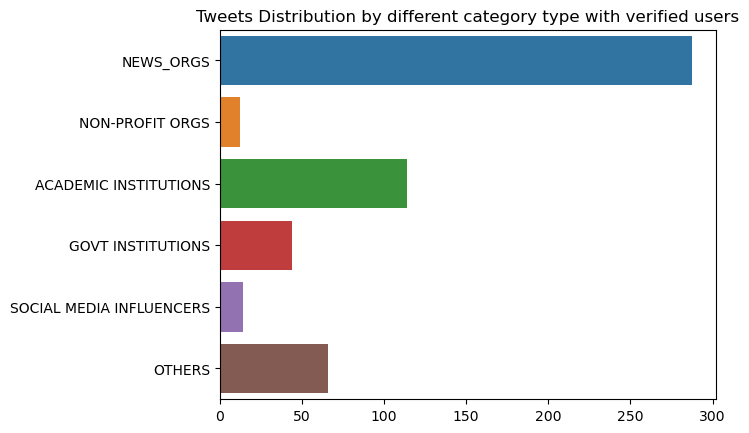

In [151]:
#Total tweets by different types of organizations
ax = sns.barplot(x=total_tweets_y, y=total_tweets_x)
plt.title('Tweets Distribution by different category type with verified users')

Text(0.5, 1.0, 'Top-10 Twitterers with Original Tweets')

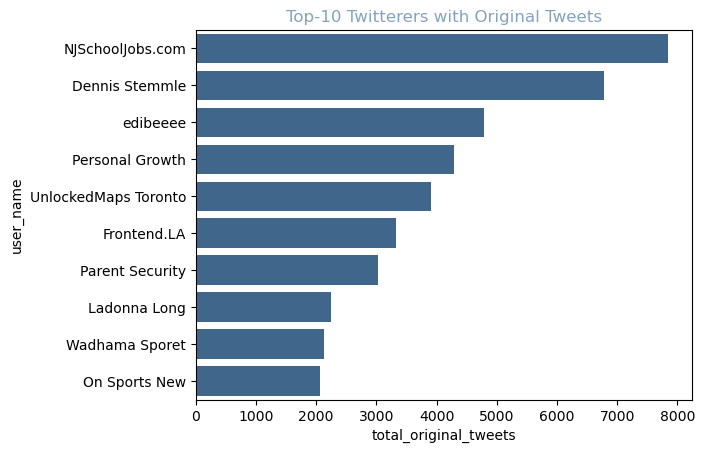

In [152]:
#Top-10 Twitterers with Original Tweets
sns.barplot(y=org_top10['user_name'], x=org_top10['total_original_tweets'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Top-10 Twitterers with Original Tweets',color=(0.2, 0.4, 0.6, 0.6))

Text(0.5, 1.0, 'Top-10 verified Twitterers with Original Tweets')

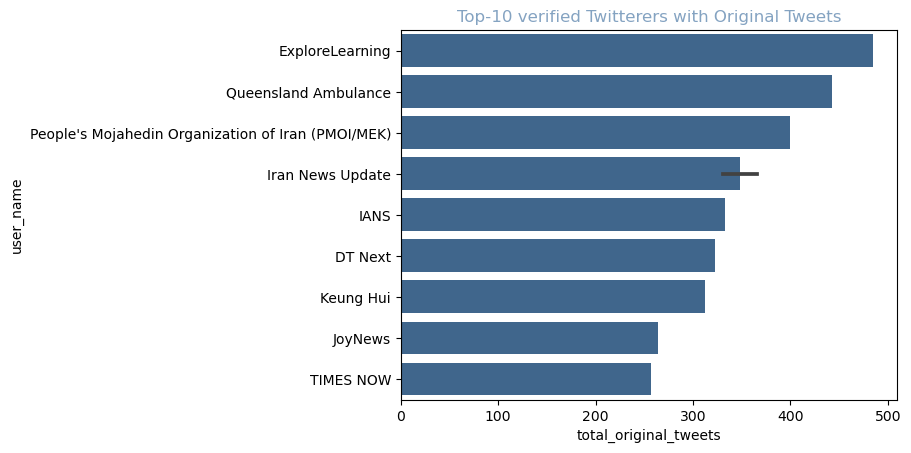

In [153]:
#Top-10 verified Twitterers with Original Tweets
sns.barplot(y=org_v_top10['user_name'], x=org_v_top10['total_original_tweets'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Top-10 verified Twitterers with Original Tweets',color=(0.2, 0.4, 0.6, 0.6))

Text(0.5, 1.0, 'Original Tweets Distribution by different category type with verified users')

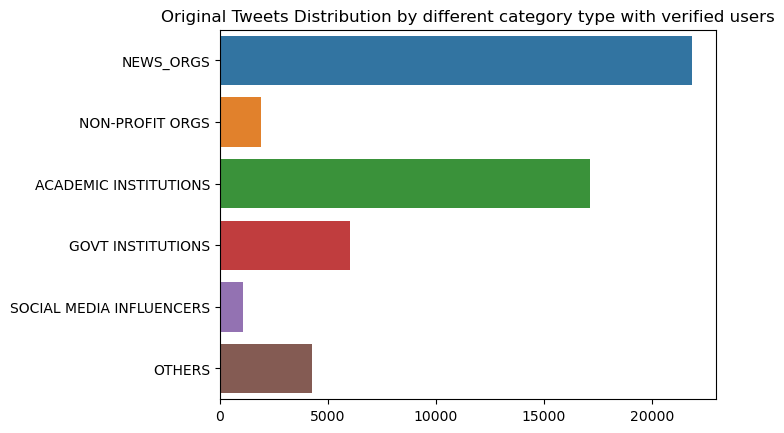

In [39]:
#Original tweets by different types of organizations
ax = sns.barplot(x=org_tweets_y, y=org_tweets_x)
plt.title('Original Tweets Distribution by different category type with verified users')

Text(0.5, 1.0, 'Top-10 Twitterers with Retweets')

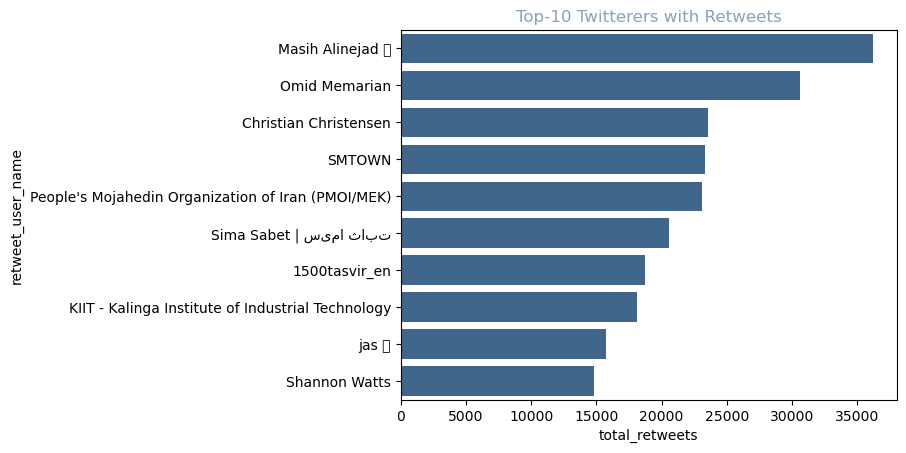

In [154]:
#Top-10 Twitterers with  Retweets
sns.barplot(y=retweet_top10['retweet_user_name'], x=retweet_top10['total_retweets'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Top-10 Twitterers with Retweets',color=(0.2, 0.4, 0.6, 0.6))

Text(0.5, 1.0, 'Top-10 verified Twitterers with Retweets')

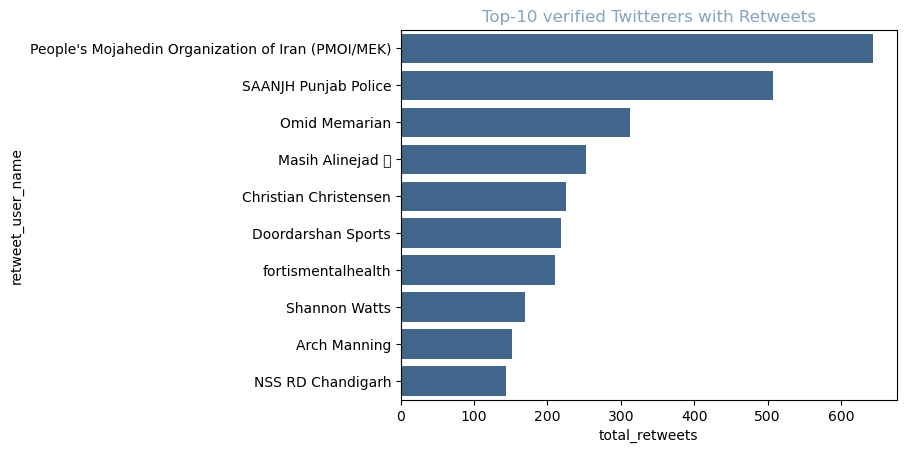

In [155]:
#Top-10 Twitterers with  Retweets
sns.barplot(y=retweets_v_top10['retweet_user_name'], x=retweets_v_top10['total_retweets'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Top-10 verified Twitterers with Retweets',color=(0.2, 0.4, 0.6, 0.6))

Text(0.5, 1.0, 'Retweets Distribution by different category type with verified users')

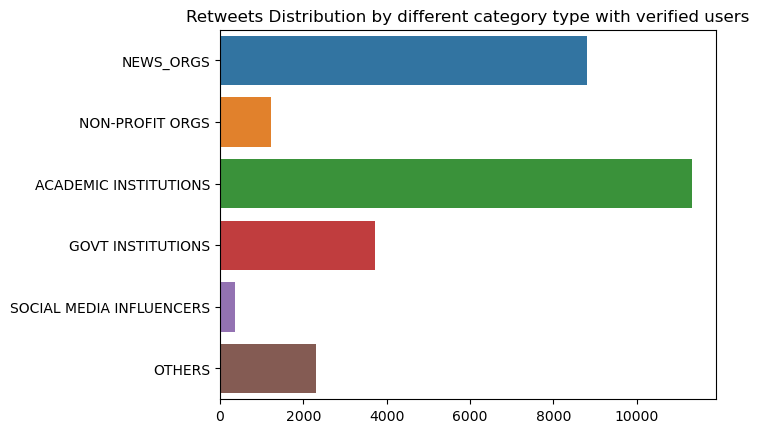

In [51]:
#Retweets by different types of organizations
ax = sns.barplot(x=retweets_y, y=retweets_x)
plt.title('Retweets Distribution by different category type with verified users')